In [1]:
import numpy as np
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras as keras
seed_value = 10
import random
random.seed(seed_value)
import tensorflow as tf
# tf.random.set_seed(seed_value)
import numpy as np
# np.random.seed(seed_value)
from sklearn.utils import shuffle

In [2]:
a = np.load('QIS_EXAM_200Events.npz', allow_pickle = True)

In [3]:
test = a['test_input.npy'].tolist()
train = a['training_input.npy'].tolist()

Normalized the feature inputs by subtracting by mean and diving by the standard deviation for each feature separately. 

In [4]:
x_train = train['0']
x_train = np.append(x_train, train['1'], axis = 0)
y_train = np.array([0]*50 + [1]*50)
x_train, y_train = shuffle(x_train, y_train, random_state=seed_value)

#Normalize the features
mean = np.average(x_train, axis = 0)
var = (np.average(x_train**2, axis = 0) - mean**2)
x_train = (x_train - mean)/np.sqrt(var)

In [5]:
x_test = test['0']
x_test = np.append(x_test, test['1'], axis = 0)
y_test = np.array([0]*50 + [1]*50)
x_test, y_test = shuffle(x_test, y_test, random_state=seed_value)

#Normalize
x_test = (x_test - mean)/np.sqrt(var)

Visualizing dataset by projecting it to 2 dimensions
As we can see, clustering won't work because each of the 4 clusters have mixed labels

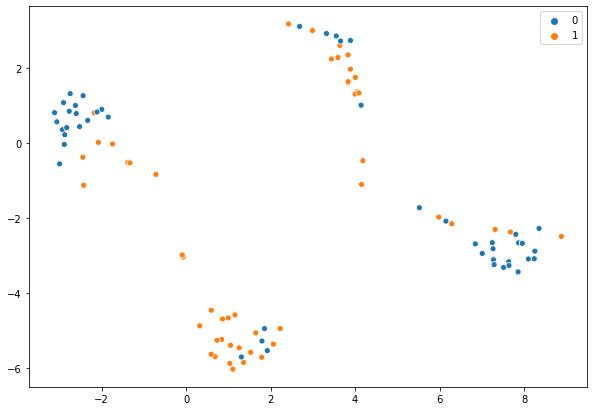

In [6]:
train_embed = sklearn.manifold.TSNE(2).fit_transform(x_train)
plt.figure(figsize=(10,7))
sns.scatterplot(train_embed[:,0], train_embed[:,1], hue=y_train, legend='full')

# Neural Network

Neural Networks have the amazing ability to perform many non linear transformations on data so as to learn multi level representations of the data by itself, without any explicit feature engineering. 
Here, I have written a template code for training a neural network, with arbitrary number of hidden units (argument 'units'). As can be seen by a trial run with no hidden layers (basically logistic regression), the neural network reaches a saturation after 20 epochs, where the training accuracy and testing accuracy don't increase any further. It may be likely that the loss (sparse categorical entropy) is stuck at a local minima.
This requires us to tune hyper parameters and start with different weight initializations, to see if the model can perform better.

In [52]:
# Training code template
def train(lr, batch_size, units, verbose = 0):
    keras.backend.clear_session()
    model = keras.Sequential()
    model.add(keras.layers.Input(shape = (5,)))
    for u in units:
        model.add(keras.layers.Dense(u, activation = 'relu',
                                    kernel_initializer='random_uniform',
                                    bias_initializer='zero'))
    model.add(keras.layers.Dense(1, activation = 'sigmoid',
                                kernel_initializer='random_uniform',
                                bias_initializer='zero'))

    model.compile(optimizer = keras.optimizers.Adam(lr = lr), loss = 'binary_crossentropy', metrics = ['accuracy'])
    history = model.fit(x = x_train, y = y_train, epochs = 20, batch_size = batch_size, validation_data = (x_test, y_test),
                       verbose = verbose)
    return np.max(history.history['val_accuracy']), history.history['accuracy'][np.argmax(history.history['val_accuracy'])]
train(0.01, 32, [], 1)

Train on 100 samples, validate on 100 samples
Epoch 1/20
100/100 [==============================] - 0s 4ms/sample - loss: 0.6853 - accuracy: 0.5800 - val_loss: 0.6759 - val_accuracy: 0.7100
Epoch 2/20
100/100 [==============================] - 0s 196us/sample - loss: 0.6667 - accuracy: 0.8000 - val_loss: 0.6668 - val_accuracy: 0.6900
Epoch 3/20
100/100 [==============================] - 0s 249us/sample - loss: 0.6518 - accuracy: 0.8100 - val_loss: 0.6587 - val_accuracy: 0.7100
Epoch 4/20
100/100 [==============================] - 0s 228us/sample - loss: 0.6368 - accuracy: 0.8200 - val_loss: 0.6523 - val_accuracy: 0.7000
Epoch 5/20
100/100 [==============================] - 0s 239us/sample - loss: 0.6231 - accuracy: 0.8200 - val_loss: 0.6463 - val_accuracy: 0.7000
Epoch 6/20
100/100 [==============================] - 0s 249us/sample - loss: 0.6099 - accuracy: 0.8200 - val_loss: 0.6412 - val_accuracy: 0.7100
Epoch 7/20
100/100 [==============================] - 0s 239us/sample - loss: 0.

(0.72, 0.81)

Here, the program tries different combinations of hyper-parameter values (learning rate and Batch size), and also run the training code multiple times (each time with different weight initializations, distributed uniformly) and record maximum validation accuracy reached. In this section, the model is a simple logistic regression model.

In [53]:
# Doing Grid Search on learning rates and batch sizes for logistic regression (no hidden units)
def grid_search(units, verbose = False):
    LR = 10**(np.arange(start = -5.0, stop = 1, step = 1.0))
    BS = [1, 8, 16, 32, 64]
    maxm_val_acc = 0
    argmax_acc = 0
    for lr in LR:
        for batch_size in BS:
            if verbose:
                print('lr: ', lr, 'batch size: ', batch_size)
            val_accs = []
            accs = []
                      
            for rep in range(5): ## Trying different random initializations of weights
                val_acc, acc = train(lr, batch_size, units, 0)
                accs += [acc]
                val_accs += [val_acc]
                
            if verbose:
                print('Validation accuracy: ', np.max(val_accs), ' Training accuracy: ', accs[np.argmax(val_accs)], '\n')
            if maxm_val_acc<np.max(val_accs):
                maxm_val_acc = np.max(val_accs)
                argmax_acc = accs[np.argmax(val_accs)]
    print('Maximum Validation Accuracy achieved: ', maxm_val_acc, '\nCorresponding training accuracy: ', argmax_acc)
grid_search([], True) # No hidden layer

lr:  1e-05 batch size:  1
Validation accuracy:  0.57  Training accuracy:  0.65 

lr:  1e-05 batch size:  8
Validation accuracy:  0.65  Training accuracy:  0.73 

lr:  1e-05 batch size:  16
Validation accuracy:  0.6  Training accuracy:  0.6 

lr:  1e-05 batch size:  32
Validation accuracy:  0.66  Training accuracy:  0.75 

lr:  1e-05 batch size:  64
Validation accuracy:  0.45  Training accuracy:  0.38 

lr:  0.0001 batch size:  1
Validation accuracy:  0.74  Training accuracy:  0.71 

lr:  0.0001 batch size:  8
Validation accuracy:  0.72  Training accuracy:  0.76 

lr:  0.0001 batch size:  16
Validation accuracy:  0.72  Training accuracy:  0.73 

lr:  0.0001 batch size:  32
Validation accuracy:  0.63  Training accuracy:  0.56 

lr:  0.0001 batch size:  64
Validation accuracy:  0.45  Training accuracy:  0.53 

lr:  0.001 batch size:  1
Validation accuracy:  0.72  Training accuracy:  0.74 

lr:  0.001 batch size:  8
Validation accuracy:  0.72  Training accuracy:  0.82 

lr:  0.001 batch si

Here, I perform grid search on various neural network structures with different number of layers and units. The maximum validation accuracy that we get out of all these models is 0.77, but all models perform almost equally well. 

In [54]:
# Trying different NN models with different number and sizes of hidden units
units =[
    [2],
    [8],
    [32],
    [1024],
    [2, 2],
    [8, 16],
    [16, 8],
    [64, 64],
    [64, 8],
    [1024, 1024],
    [64, 32, 8]
]
for u in units:
    print('Units: ', u)
    grid_search(u)
    print('\n')

Units:  [2]
Maximum Validation Accuracy achieved:  0.76 
Corresponding training accuracy:  0.76


Units:  [8]
Maximum Validation Accuracy achieved:  0.76 
Corresponding training accuracy:  0.69


Units:  [32]
Maximum Validation Accuracy achieved:  0.76 
Corresponding training accuracy:  0.54


Units:  [1024]
Maximum Validation Accuracy achieved:  0.77 
Corresponding training accuracy:  0.73


Units:  [2, 2]
Maximum Validation Accuracy achieved:  0.74 
Corresponding training accuracy:  0.73


Units:  [8, 16]
Maximum Validation Accuracy achieved:  0.76 
Corresponding training accuracy:  0.55


Units:  [16, 8]
Maximum Validation Accuracy achieved:  0.76 
Corresponding training accuracy:  0.72


Units:  [64, 64]
Maximum Validation Accuracy achieved:  0.76 
Corresponding training accuracy:  0.72


Units:  [64, 8]
Maximum Validation Accuracy achieved:  0.76 
Corresponding training accuracy:  0.72


Units:  [1024, 1024]
Maximum Validation Accuracy achieved:  0.76 
Corresponding training accur